<a href="https://colab.research.google.com/github/nedlecky/CSC485B/blob/main/CSC485_200_PartClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier

In [1]:
# Setup and Support Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# This makes us reproducible (and we can adjust fixed_seed to get different results)
fixed_seed = 1

# Return n random floats between lo and hi as 1-column NumPy matrix
def rand_nlohi(n=1, lo=0, hi=1):
  # This is just a uniform distribution from lo to hi... we can adjust if appropriate in the future
  return (np.random.rand(n) * (hi - lo) + lo).reshape(-1,1)

# Often a good idea as long as we are keeping values near +/- 1... don't need exponential notation
np.set_printoptions(floatmode='fixed', precision=4, suppress=True)
# This will get us all 400 rows printed... which fails past 40 x 2 columns
np.set_printoptions(threshold=sys.maxsize)

# Simple numpy array print with optional push to file
def nprint(m, name='', also_write_file=False):
  print(f"{name} {m.shape} {m.dtype}")
  print(m)
  if also_write_file and name != '':
    fprint(m, name)

# Print numpy array to file (needs name)
path='classifier/'
def fprint(m, name=''):
  if name != '':
    with open(path +  name, 'w') as f:
      print(f"{name} {m.shape} {m.dtype}", file=f)
      print(m, file=f)
  else:
    print('fprint needs a name!')

# Remove a file and don't complain if it doesn't exist
def remove_file(name):
  try:
    os.remove(name)
  except:
    return

def empty_directory(path):
  for file_name in os.listdir(path):
    # construct full file path
    file = path + file_name
    if os.path.isfile(file):
        print('Deleting file:', file)
        os.remove(file)

if not os.path.exists(path):
  os.mkdir(path)

empty_directory(path)


Deleting file: classifier/X_train
Deleting file: classifier/X_test_std
Deleting file: classifier/y_train
Deleting file: classifier/X
Deleting file: classifier/X_train_std
Deleting file: classifier/y
Deleting file: classifier/Xy
Deleting file: classifier/X_test
Deleting file: classifier/y_test


# Choosing a classification algorithm

In [2]:
# Build some test data
import random

#X = [area, perimeter, num_holes, avg_holesize]

def gen_small_part():
  area = (random.random() + 1) * 100
  perimeter = np.sqrt(area) * (random.random()+1)
  num_holes = random.randint(3,5)
  avg_holesize = (random.random() + 1) * 10
  ID = 0
  return np.array([area, perimeter, num_holes, avg_holesize, ID]).reshape(1,-1)

def gen_medium_part():
  area = (random.random() + 1) * 200
  perimeter = np.sqrt(area) * (random.random()+1)
  num_holes = random.randint(3,7)
  avg_holesize = (random.random() + 1) * 12
  ID = 1
  return np.array([area, perimeter, num_holes, avg_holesize, ID]).reshape(1,-1)

def gen_large_part():
  area = (random.random() + 1) * 300
  perimeter = np.sqrt(area) * (random.random()+1)
  num_holes = random.randint(5,8)
  avg_holesize = (random.random() + 1) * 11
  ID = 2
  return np.array([area, perimeter, num_holes, avg_holesize, ID]).reshape(1,-1)

n_small = 50
n_medium = 50
n_large = 50
Xy = gen_small_part()

for i in range(n_small-1):
  Xy = np.vstack([Xy, gen_small_part()])
for i in range(n_medium):
  Xy = np.vstack([Xy, gen_medium_part()])
for i in range(n_large):
  Xy = np.vstack([Xy, gen_large_part()])

fprint(Xy, 'Xy')

X = Xy[:,0:4]
y = Xy[:,4].astype(int)  
fprint(X, 'X')
fprint(y, 'y')


Splitting data into 70% training and 30% test data:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)
fprint(X_train, 'X_train')
fprint(X_test, 'X_test')
fprint(y_train, 'y_train')
fprint(y_test, 'y_test')


In [4]:
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test))

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


Standardizing the features:

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
fprint(X_train_std, 'X_train_std')
fprint(X_test_std, 'X_test_std')

<br>
<br>

## Training a perceptron via scikit-learn

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

**Note**

- You can replace `Perceptron(n_iter, ...)` by `Perceptron(max_iter, ...)` in scikit-learn >= 0.19. The `n_iter` parameter is used here deliberately, because some people still use scikit-learn 0.18.

In [7]:
y_pred = ppn.predict(X_test_std)
print('Misclassified TEST examples: %d' % (y_test != y_pred).sum())

Misclassified TEST examples: 10


In [8]:
y_pred_train = ppn.predict(X_train_std)
print('Misclassified TRAIN examples: %d' % (y_train != y_pred_train).sum())

Misclassified TRAIN examples: 15


In [9]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.778


In [10]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.778


Training a perceptron model using the standardized training data:

# Modeling class probabilities via logistic regression

### Logistic regression intuition and conditional probabilities

In [11]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [12]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)



### Training a logistic regression model with scikit-learn

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)



LogisticRegression(C=100.0, multi_class='ovr', random_state=1)

In [14]:
lr.predict_proba(X_test_std[:3, :])

array([[0.0000, 0.1336, 0.8664],
       [0.5864, 0.4136, 0.0000],
       [0.5977, 0.4023, 0.0000]])

In [15]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1.0000, 1.0000, 1.0000])

In [16]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [17]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [18]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

<br>
<br>

### Tackling overfitting via regularization

In [19]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='lbfgs',
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)


<br>
<br>

In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)



SVC(kernel='linear', random_state=1)

## Alternative implementations in scikit-learn

In [21]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

<br>
<br>

In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)


SVC(gamma=0.2, random_state=1)

In [23]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)


SVC(gamma=100.0, random_state=1)

# Decision tree learning

## Maximizing information gain - getting the most bang for the buck

<br>
<br>

## Building a decision tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))


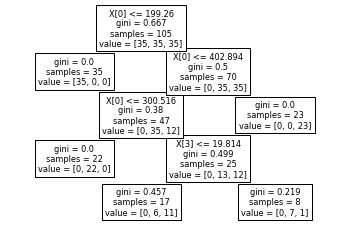

In [25]:
from sklearn import tree

tree.plot_tree(tree_model)
#plt.savefig('images/03_21_1.pdf')
plt.show()

<br>
<br>

In [27]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['small', 
                                        'medium',
                                        'large'],
                           feature_names=['area', 
                                          'perimeter',
                                          'num_holes',
                                          'avg_holesize'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

## Combining weak to strong learners via random forests

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)



RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=1)

# K-nearest neighbors - a lazy learning algorithm

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)



KNeighborsClassifier()